# 구내식당 식수 인원 예측 AI 경진대회
- 주제 : 구내식당의 요일별 점심, 저녁식사를 먹는 인원을 예측
- 주최 : 한국토지주택공사
- 주관 : DACON

#### ※ 상위 3% 달성( private 기준 11/480 )

## 1. 전처리

### 1-1 변수 생성
- 공휴일 전후, 인원 변화 변수 생성
- 일자에서 월, 주, 일을 분리
- 휴가, 출장 등의 변수 비율화
- 요일 레이블 인코딩화


### 1-2 EDA 및 명목형 변수의 순서형 변환
- 요일별, 월별, 주별 중식 및 석식 수요 차이 파악 후 영향력에 따른 순서형 변환

## 2. 메뉴(텍스트)의 변수화
- 텍스트로 구성된 메뉴 변수를 TF-IDF를 통해 변수화
- 모든 메뉴를 변수화하기엔 차원이 상당히 커지기 때문에 OLS를 통해 유의한 메뉴만을 변수로서 사용
- train/test에서 중복되는 메뉴만 변수로서 사용(data leakage)

## 3. 예측 모델 구축
- pycaret 패키지를 통해 가장 우수한 모델(MAE 기준)을 선정
- 선정된 모델의 하이퍼 파라미터 튜닝 후 앙상블을 통해 최종 예측값 도출

### 패키지 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import setup, compare_models, blend_models,tune_model,predict_model,get_config, finalize_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.family'] = 'Gulim'

from workalendar.asia import SouthKorea
import pendulum

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## 1-1 변수 생성
- 공휴일 전후, 인원 변화 변수 생성
- 일자에서 월, 주, 일을 분리
- 휴가, 출장 등의 변수 비율화
- 요일 레이블 인코딩화

### 파생변수 생성

In [4]:
def is_holiday(date):
    holidays = list(map(str, pd.Series(np.array(SouthKorea().holidays(int(date[:4])))[:, 0])))
    
    yesterday = str(np.datetime64(date) - 1)
    tomorrow = str(np.datetime64(date) + 1)

    if tomorrow in holidays and yesterday in holidays:
        return'S'
    if tomorrow in holidays:
        return 'T'
    elif yesterday in holidays:
        return 'Y'
    else : 
        return 'N'

def week_of_month(x):
    dt = pendulum.parse(x)
    
    wom = dt.week_of_month
    if wom < 0:
        wom += 52
    return str(wom)
    

df = pd.concat([train[['본사정원수', '일자']], test[['본사정원수', '일자']]])
df['년월'] = df['일자'].apply(lambda x : x[:7])
df = df[['년월', '본사정원수']].groupby(by=['년월'], as_index=False).mean()

def member_change(date):
    this_month = date[:7]
    last_month = str(np.datetime64(this_month) - 1)
    
    this_month_member = int(df[df['년월'] == this_month]['본사정원수'])
    last_month_member = int(df[df['년월'] == last_month]['본사정원수'])
    
    
    return  this_month_member - last_month_member

train['공휴일전후'] = train['일자'].apply(is_holiday)
test['공휴일전후'] = test['일자'].apply(is_holiday)

# train['몇주차'] = train['일자'].apply(week_of_month)
# test['몇주차'] = test['일자'].apply(week_of_month)

train = train[train['일자'] > '2016-03']
train['인원변화'] = train['일자'].apply(member_change)
test['인원변화'] = test['일자'].apply(member_change)

In [5]:
train['월'] = pd.DatetimeIndex(train['일자']).month
test['월'] = pd.DatetimeIndex(test['일자']).month
train['주'] = pd.DatetimeIndex(train['일자']).week
test['주'] = pd.DatetimeIndex(test['일자']).week
train['일'] = pd.DatetimeIndex(train['일자']).day
test['일'] = pd.DatetimeIndex(test['일자']).day

train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

In [6]:
weekday = {
    '월': 1,
    '화': 2,
    '수': 3,
    '목': 4,
    '금': 5
}

train['요일'] = train['요일'].map(weekday)
test['요일'] = test['요일'].map(weekday)

## 1-2 EDA 및 명목형 변수의 순서형 변환
- 변수 별 수요 차이 파악 후 영향력에 따라 명목형 변수를 순서형 변수로 변환

### 1) 요일 별 중식, 석식 수요

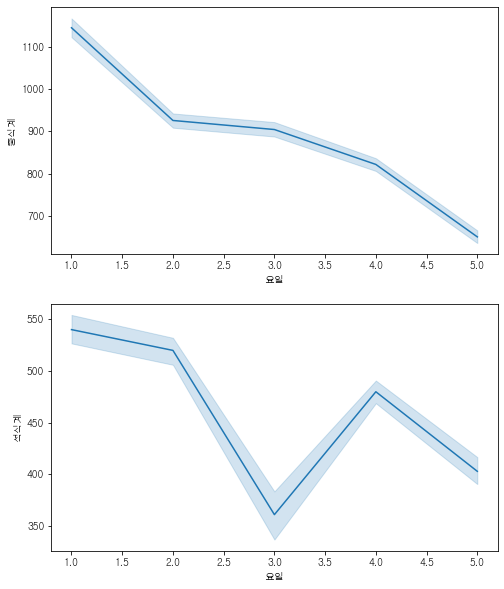

In [7]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,10)
sns.lineplot(data=train, x='요일', y='중식계', ax=ax[0])
sns.lineplot(data=train, x='요일', y='석식계', ax=ax[1])
plt.show()

- 중식의 경우 금요일로 갈수록 비슷한 양상으로 줄어드는 경향을 보임
- 하지만 석식의 경우 수요일이 가장 낮은 수요를 보임 -> 이를 참고하여 레이블 인코딩

#### 요일 순서형 변환

In [8]:
weekday_rank4dinner = {
    1: 1,
    2: 2,
    3: 5,
    4: 3,
    5: 4,
}

train['요일(석식)'] = train['요일'].map(weekday_rank4dinner)
test['요일(석식)'] = test['요일'].map(weekday_rank4dinner)

train['요일(중식)'] = train['요일']
test['요일(중식)'] = test['요일']

### 2) 월별 중식, 석식 수요

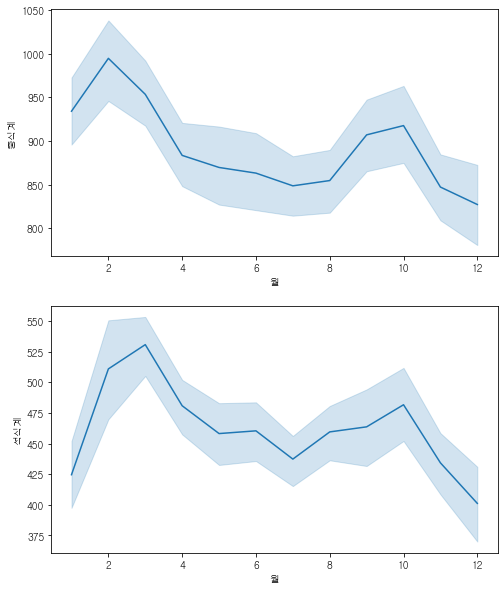

In [9]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,10)
sns.lineplot(data=train, x='월', y='중식계', ax=ax[0])
sns.lineplot(data=train, x='월', y='석식계', ax=ax[1])
plt.show()

- 중식은 2월, 석식은 3월이 가장 수요가 많음
- 중식, 석식은 월별로 큰 차이가 없음

#### 월 순서형 변환

In [10]:
# 중식
month_rank4lunch = {
    1: 3,
    2: 1,
    3: 2,
    4: 6,
    5: 7,
    6: 8,
    7: 10,
    8: 9,
    9: 5,
    10: 4,
    11: 11,
    12: 12
}
train['월(중식)'] = train['월'].map(month_rank4lunch)
test['월(중식)'] = test['월'].map(month_rank4lunch)

# 석식
month_rank4dinner = {
    1: 11,
    2: 2,
    3: 1,
    4: 4,
    5: 8,
    6: 6,
    7: 9,
    8: 7,
    9: 5,
    10: 3,
    11: 10,
    12: 12
}
train['월(석식)'] = train['월'].map(month_rank4dinner)
test['월(석식)'] = test['월'].map(month_rank4dinner)

### 3) 주별 중식, 석식 수요

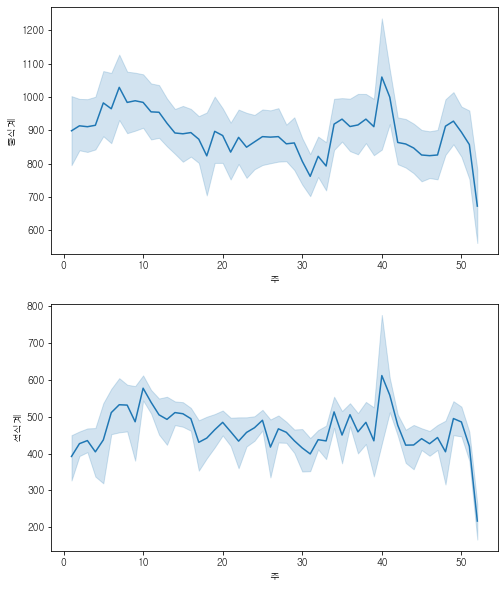

In [11]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,10)
sns.lineplot(data=train, x='주', y='중식계', ax=ax[0])
sns.lineplot(data=train, x='주', y='석식계', ax=ax[1])
plt.show()

#### 주 순서형 변환

In [12]:
rank = pd.DataFrame(range(1,53))
week_rank_lunch = pd.pivot_table(train,values='중식계',index='주').sort_values(by='중식계').reset_index().drop('중식계',axis=1)
week_rank_dinner = pd.pivot_table(train,values='석식계',index='주').sort_values(by='석식계').reset_index().drop('석식계',axis=1)


week_rank4lunch = {}
for i in range(len(rank)):
    week_rank4lunch[week_rank_lunch['주'][i]] = rank[0][i]


week_rank4dinner = {}
for i in range(len(rank)):
    week_rank4dinner[week_rank_dinner['주'][i]] = rank[0][i]
    
    
train['주(중식)'] = train['주'].map(week_rank4lunch)
test['주(중식)'] = test['주'].map(week_rank4lunch)

train['주(석식)'] = train['주'].map(week_rank4dinner)
test['주(석식)'] = test['주'].map(week_rank4dinner)

## 2. 메뉴 변수화
- 텍스트로 구성된 메뉴 변수를 TF-IDF를 통해 변수화
- 모든 메뉴를 변수화하기엔 차원이 상당히 커지기 때문에 OLS를 통해 유의한 메뉴만을 변수로서 사용
- train/test에서 중복되는 메뉴만 변수로서 사용(data leakage)

In [13]:
menu_train = train[['조식메뉴','중식메뉴','석식메뉴']]
menu_test = test[['조식메뉴','중식메뉴','석식메뉴']]
print(menu_train.shape)
print(menu_test.shape)

(1187, 3)
(50, 3)


In [14]:
def clean_split(df):
    df = df.split()
    for j in df:
        if '(' in j:
            del df[df.index(j)]
    for i in df:
        if '쌀밥' in i:
            del df[df.index(i)] 
    for q in df:
        if '김치' in q:
            del df[df.index(q)]
    
    return df

In [15]:
menu_train['조식메뉴_prepro'] = menu_train['조식메뉴'].apply(clean_split)
menu_train['중식메뉴_prepro'] = menu_train['중식메뉴'].apply(clean_split)
menu_train['석식메뉴_prepro'] = menu_train['석식메뉴'].apply(clean_split)

menu_test['조식메뉴_prepro'] = menu_test['조식메뉴'].apply(clean_split)
menu_test['중식메뉴_prepro'] = menu_test['중식메뉴'].apply(clean_split)
menu_test['석식메뉴_prepro'] = menu_test['석식메뉴'].apply(clean_split)

In [16]:
lunch_train= menu_train.중식메뉴_prepro.tolist()
lunch_test= menu_test.중식메뉴_prepro.tolist()
dinner_train = menu_train.석식메뉴_prepro.tolist()
dinner_test = menu_test.석식메뉴_prepro.tolist()

### 1) 벡터화

In [17]:
lunch_list_train = []
for i in lunch_train:
    if len(i) == 0:
        continue
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    lunch_list_train.append(string)
lunch_list_train

['쇠고기미역국 주꾸미볶음 맛살계란말이 아삭고추무침',
 '근대된장국 탕수육 새송이버섯조림 무생채 요구르트',
 '부대찌개 가자미튀김 메추리알조림 열무된장나물 깍두기',
 '콩나물국 닭갈비 모둠묵*양념장 톳두부무침',
 '차돌박이찌개 소세지구이 풋마늘초무침 깍두기',
 '북어국 돈육장조림 홍어무침 시금치나물',
 '고추장찌개 닭데리야끼조림 해물파전 취나물',
 '배추된장국 수제돈가스 탕평채 쫄면무침',
 '어묵국 돈육고추장볶음 모둠양채쌈*쌈장 콩나물파채무침',
 '쑥국 소불고기 골뱅이무침*소면 마늘쫑볶음',
 '곤드레밥 미니채소떡갈비 두부계란부침 무나물',
 '사골우거지국 탕수어 파래김*양념장 깻순나물 깍두기',
 '시금치국 훈제오리구이 연근땅콩조림 쌈무/부추생채',
 '꽃게탕 버섯불고기 계란말이 도토리묵무침',
 '쇠고기샤브국 코다리강정 유채나물 깍두기',
 '콩나물밥*달래장 맑은국 치킨텐더*요거트D 땅콩조림 실곤약초무침',
 '북어계란국 쇠고기장조림 오징어초무침 시래기나물',
 '닭개장 자반고등어구이 비엔나볶음 열무나물 배추겉절이',
 '얼갈이된장국 닭갈비 해파리냉채 취나물',
 '옹심이만두국 주꾸미볶음 새송이버섯전 치커리유자청생채',
 '봄새싹비빔밥 쪽파국 오징어튀김 알감자버터구이 오렌지',
 '매운콩나물국 돈육굴소스볶음 동태전 봄동나물',
 '버섯들깨탕 갈치조림 우엉잡채 아삭고추무침',
 '순두부찌개 쇠불고기 브로컬리맛살볶음 풋마늘초무침',
 '북어국 오징어볶음*소면 모둠소시지구이 시금치나물',
 '올갱이아욱국 제육볶음 두부조림 모둠쌈*쌈장',
 '어묵국 매운돼지갈비찜 해물파전 무생채',
 '배추된장국 순살양념치킨 메추리알조림 콩나물무침',
 '시래기국 훈제오리구이 무쌈/양파절임 풋마늘초무침',
 '부대찌개 쇠고기단호박조림 열무나물 시금치나물',
 '수제비국 돈육굴소스볶음 양배추쌈 무생채',
 '냉이된장찌개 닭데리야끼조림 도라지초무침 콩나물무침',
 '배추된장국 돈육강정 콩나물잡채 브로컬리두부무침',
 '육개장 꽁치한마리구이 고기전 해초무침',
 '콩나

In [18]:
lunch_list_test = []
for i in lunch_test:
    if len(i) == 0:
        continue
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    lunch_list_test.append(string)

In [19]:
dinner_list_train = []
for i in dinner_train:
    if len(i) == 0:
        i = ['.']
        string = i[0]
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    dinner_list_train.append(string)
dinner_list_train

['된장찌개 버섯불고기 콩나물겨자채 양념깻잎지',
 '멸치주먹밥 우동 떡볶이 군고구마 단무지',
 '오징어국 미트볼조림 옥수수전 부추생채',
 '대구찌개 돈육굴소스볶음 감자채볶음 물파래무침',
 '카레덮밥 가쯔오장국 수제고로케*케찹 과일샐러드 오복지',
 '육개장 생선까스*탈탈소스 야채계란찜 콩나물무침',
 '볶음밥 짬뽕 개성감자만두 타코야끼 꼬들단무지',
 '연두부탕 코다리무조림 고추잡채*꽃빵 봄동겉절이',
 '달래된장찌개 간장찜닭 통도라지구이 참나물생채',
 '짜장잡채덮밥 계란파국 참치야채전 꽃맛살샐러드 오이무침',
 '뼈해장국 해물청경채볶음 버섯메밀전 야채스틱*쌈장',
 '토마토스파게티 양송이스프 미니햄버거 단호박범벅 무피클/음료',
 '닭곰탕 임연수찜 어묵곤약볶음 돌나물초장 석박지',
 '수제비국 아귀콩나물찜 새송이버섯볶음 봄동겉절이',
 '굴소스파인볶음밥 가쯔오장국 찹쌀순대볶음 궁중떡찜 두반장가지나물',
 '알탕 동그랑땡전 마파두부 시금치나물',
 '참치회덮밥 미소장국 군만두 콘샐러드 바나나',
 '냉이된장찌개 누룽지탕수육 감자채볶음 청경채무침',
 '콩비지찌개 유산슬 해물까스*탈탈소스 도라지나물',
 '햄볶음밥 유부장국 돈육씨앗강정 해초무침 깨찰빵',
 '어묵국 청포묵무침 애호박나물 깍두기',
 '주먹밥 잔치국수 또띠아피자 과일샐러드 오이피클',
 '쇠고기미역국 순살깐풍기 계란찜 숙주미나리나물',
 '된장찌개 고등어조림 고기전 부추생채',
 '가쯔오장국 감자치즈구이 꽃맛살샐러드 단무지 깍두기',
 '매운버섯국 찜닭 탕평채 청경채생채',
 '김밥 우동 야채튀김 조각사과 오복지',
 '오징어국 미니함박 멸치호두볶음 치커리사과무침',
 '쇠고기무국 가자미찜 계란야채말이 돌나물오이무침',
 '치킨마요덮밥 유부주머니국 떡볶이 단무지무침 오렌지',
 '비빔밥 팽이버섯장국 새우또띠아 견과류조림 피크닉',
 '들깨미역국 수제돈가스 감자범벅 참나물생채',
 '꽃게탕 유산슬 야채계란찜 두반장가지나물',
 '낙지비빔밥 유부장국 새싹피자 과일샐러드 꼬들단무지',
 '어묵

In [20]:
dinner_list_test = []
for i in dinner_test:
    if len(i) == 0:
        i = ['.']
        string = i[0]
    else:
        string = i[0]
    for w in i[1:]:
        string += " "
        string += w
    dinner_list_test.append(string)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
lunch_matrix_train = vectorizer.fit_transform(lunch_list_train)
lunch_df_train = pd.DataFrame(lunch_matrix_train.toarray(), columns=vectorizer.get_feature_names())

vectorizer = TfidfVectorizer()
dinner_matrix_train = vectorizer.fit_transform(dinner_list_train)
dinner_df_train = pd.DataFrame(dinner_matrix_train.toarray(), columns=vectorizer.get_feature_names())

vectorizer = TfidfVectorizer()
lunch_matrix_test = vectorizer.fit_transform(lunch_list_test)
lunch_df_test = pd.DataFrame(lunch_matrix_test.toarray(), columns=vectorizer.get_feature_names())

vectorizer = TfidfVectorizer()
dinner_matrix_test = vectorizer.fit_transform(dinner_list_test)
dinner_df_test = pd.DataFrame(dinner_matrix_test.toarray(), columns=vectorizer.get_feature_names())

In [22]:
# 중복 메뉴 선정
lunch_intersection = list(set(lunch_df_train.columns) & set(lunch_df_test.columns))
print(len(lunch_intersection))
dinner_intersection = list(set(dinner_df_train.columns) & set(dinner_df_test.columns))
print(len(dinner_intersection))

146
109


In [26]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

lunch_df_train = lunch_df_train.reset_index(drop=True)
lunch_df_test = lunch_df_test.reset_index(drop=True)

dinner_df_train = dinner_df_train.reset_index(drop=True)
dinner_df_test = dinner_df_test.reset_index(drop=True)

lunch_df_f = pd.concat([train[['공휴일전후', '요일(중식)','월(중식)','일','주(중식)','출근', '휴가비율', '출장비율', '야근비율', '재택비율','본사출장자수','본사휴가자수','중식계']],lunch_df_train[lunch_intersection]],axis=1)
lunch_df_test_f = pd.concat([test[['공휴일전후', '요일(중식)','월(중식)','일','주(중식)','출근', '휴가비율', '출장비율', '야근비율', '재택비율','본사출장자수','본사휴가자수']],lunch_df_test[lunch_intersection]],axis=1)


dinner_df_f = pd.concat([train[['공휴일전후', '요일(석식)','월(석식)','일','주(석식)','출근', '휴가비율', '출장비율', '야근비율', '재택비율','본사출장자수','본사휴가자수','석식계']],dinner_df_train[dinner_intersection]],axis=1)
dinner_df_test_f = pd.concat([test[['공휴일전후', '요일(석식)','월(석식)','일','주(석식)','출근', '휴가비율', '출장비율', '야근비율', '재택비율','본사출장자수','본사휴가자수']],dinner_df_test[dinner_intersection]],axis=1)

### 2) OLS를 통해 유의한 메뉴 변수 선정
- 중식 146개, 석식 109개의 메뉴를 모두 변수로서 사용하기 어려우므로 OLS를 통해 종속변수에 유의한 변수만을 변수로서 사용
- 각 변수의 p값과 회귀계수 값들을 종합적으로 고려 후 변수로서 사용

In [28]:
from statsmodels.api import OLS

#### 중식 OLS

In [29]:
lunch_df_f['공휴일전후'] = lunch_df_f['공휴일전후'].apply(lambda x: 1 if x=='Y' else 0)

In [30]:
ols = OLS(lunch_df_f['중식계'],lunch_df_f.drop(['중식계'],axis=1))
result = ols.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    중식계   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              546.1
Date:                Thu, 23 Sep 2021   Prob (F-statistic):                        0.00
Time:                        14:04:45   Log-Likelihood:                         -7149.5
No. Observations:                1187   AIC:                                  1.461e+04
Df Residuals:                    1031   BIC:                                  1.540e+04
Df Model:                         156                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
공휴일전후        129.3722     22.173      5.835      0.000      85.862     172.882
요일(중식)       -67.9568      3.786    -17.949      0.000     -75.386     -60.527
월(중식)         -1.1883      1.297     -0.916      0.360      -3.734       1.357
일             -1.0669      0.396     -2.695      0.007      -1.844      -0.290
주(중식)          1.4377      0.323      4.449      0.000       0.804       2.072
출근             0.5183      0.013     40.888      0.000       0.493       0.543
휴가비율        -100.2003    929.580     -0.108      0.914   -1924.286    1723.885
출장비율        1.893e+04    999.337     18.943      0.000     1.7e+04    2.09e+04
야근비율         224.6312     44.346      5.065      0.000     137.612     311.650
재택비율         976.9401    134.994      7.237      0.000     712.047    1241.833
본사출장자수        -7.5830      0.392    -19.349      0.000      -8.352      -6.814
본사휴가자수         0.0535      0.330      0.162      0.871      -0.594       0.701
닭볶음탕        -198.1959     59.422     -3.335      0.001    -314.797     -81.595
콩나물불고기       252.5494    155.982      1.619      0.106     -53.529     558.628
통들깨부추무침       87.4483    390.071      0.224      0.823    -677.976     852.873
요거트d         183.7206    103.955      1.767      0.077     -20.267     387.709
양념간장          -8.6315    233.324     -0.037      0.970    -466.475     449.212
쑥국          -166.6598    150.482     -1.108      0.268    -461.946     128.626
도토리묵        -166.5711    155.040     -1.074      0.283    -470.801     137.659
돈육간장불고기      175.1709     84.579      2.071      0.039       9.204     341.138
황도d          270.8113    147.391      1.837      0.066     -18.409     560.032
동파육           19.1459     91.815      0.209      0.835    -161.020     199.312
시리얼샐러드      -143.0369    198.818     -0.719      0.472    -533.171     247.098
황태국           54.1392     73.650      0.735      0.462     -90.381     198.660
시저d           57.9760    289.412      0.200      0.841    -509.929     625.881
오꼬노미계란말이     118.1366    141.347      0.836      0.403    -159.225     395.498
닭살겨자냉채         2.0348    129.926      0.016      0.988    -252.915     256.985
아욱국          -75.5161     53.833     -1.403      0.161    -181.150      30.118
안동찜닭         -76.9257     74.094     -1.038      0.299    -222.317      68.466
얼갈이된장국       -49.5138     70.488     -0.702      0.483    -187.831      88.803
두부양념조림        69.0947     74.182      0.931      0.352     -76.470     214.660
취나물무침         21.6038     97.039      0.223      0.824    -168.813     212.020
어묵매운탕        229.7261    267.172      0.860      0.390    -294.538     753.990
양념장           11.8201     48.796      0.242      0.809     -83.930     107.570
해물누룽지탕       -80.4467     60.823     -1.323      0.186    -19

In [31]:
vari_df = pd.DataFrame(result.pvalues)
vari_df[vari_df[0]<0.1].index

Index(['공휴일전후', '요일(중식)', '일', '주(중식)', '출근', '출장비율', '야근비율', '재택비율', '본사출장자수',
       '닭볶음탕', '요거트d', '돈육간장불고기', '황도d', '오이생채', '바나나', '흑임자d', '콩나물파채무침',
       '고등어구이', '수박', '청경채찜', '석박지', '파인d', '양상추샐러드', '소불고기', '우렁된장찌개',
       '동태매운탕', '오리대패불고기', '버섯매운탕'],
      dtype='object')

#### 종속변수에 유의한 중식메뉴
- '닭볶음탕', '요거트d', '돈육간장불고기', '황도d', '오이생채', '바나나', '흑임자d', '콩나물파채무침', '고등어구이', '수박', '청경채찜', '석박지', '파인d', '양상추샐러드', '소불고기', '우렁된장찌개', '동태매운탕', '오리대패불고기', '버섯매운탕'

#### 석식 OLS

In [32]:
dinner_df_f['공휴일전후'] = dinner_df_f['공휴일전후'].apply(lambda x: 1 if x=='Y' else 0)

In [33]:
ols = OLS(dinner_df_f['석식계'],dinner_df_f.drop(['석식계'],axis=1))
result = ols.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    석식계   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              218.4
Date:                Thu, 23 Sep 2021   Prob (F-statistic):                        0.00
Time:                        14:07:53   Log-Likelihood:                         -7119.2
No. Observations:                1187   AIC:                                  1.447e+04
Df Residuals:                    1072   BIC:                                  1.505e+04
Df Model:                         115                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
공휴일전후         20.9213     20.192      1.036      0.300     -18.699      60.541
요일(석식)       -14.5482      4.198     -3.466      0.001     -22.784      -6.312
월(석식)         -3.3607      1.176     -2.859      0.004      -5.667      -1.054
일             -1.8661      0.397     -4.701      0.000      -2.645      -1.087
주(석식)          1.5447      0.296      5.221      0.000       0.964       2.125
출근             0.1872      0.012     15.264      0.000       0.163       0.211
휴가비율        -116.5919    861.750     -0.135      0.892   -1807.500    1574.316
출장비율        9095.7068    940.603      9.670      0.000    7250.075    1.09e+04
야근비율         544.0580     62.590      8.692      0.000     421.245     666.871
재택비율         236.8420    128.712      1.840      0.066     -15.714     489.398
본사출장자수        -3.2607      0.356     -9.156      0.000      -3.959      -2.562
본사휴가자수         0.0754      0.306      0.247      0.805      -0.524       0.675
꼬시래기무침        -6.2478    118.234     -0.053      0.958    -238.243     225.748
수제오이피클       -14.5270     95.967     -0.151      0.880    -202.832     173.778
동태탕           66.1767    178.260      0.371      0.711    -283.601     415.954
짜사이볶음          7.6944    158.372      0.049      0.961    -303.059     318.448
브로콜리깨소스무침    270.4555    277.254      0.975      0.330    -273.567     814.478
꽃맛살샐러드        -1.9820     51.709     -0.038      0.969    -103.444      99.480
순두부찌개        101.2087     56.696      1.785      0.075     -10.039     212.457
황태국           91.3656     79.880      1.144      0.253     -65.373     248.104
우동국물         255.2988    183.969      1.388      0.166    -105.682     616.280
손수제비국        173.5972    187.755      0.925      0.355    -194.811     542.006
오꼬노미계란말이    -194.7793    198.882     -0.979      0.328    -585.021     195.463
낙지볶음         -81.7136     74.089     -1.103      0.270    -227.089      63.662
사골파국        -201.9488    290.289     -0.696      0.487    -771.548     367.650
얼갈이나물         72.2204     87.940      0.821      0.412    -100.334     244.775
고구마치즈구이      -34.3687     72.773     -0.472      0.637    -177.163     108.426
차돌된장찌개      -115.0942    173.301     -0.664      0.507    -455.141     224.953
소떡소떡         -12.7249    257.621     -0.049      0.961    -518.224     492.774
쑥갓나물          33.4084    198.143      0.169      0.866    -355.384     422.201
취나물무침         73.6826    241.752      0.305      0.761    -400.678     548.044
오복지무침       -139.4680     86.587     -1.611      0.108    -309.368      30.432
순대찜           77.0270    253.642      0.304      0.761    -420.664     574.718
어묵매운탕        146.8984    294.079      0.500      0.618    -430.138     723.934
양념장           25.5530     59.502      0.429      0.668     -9

In [34]:
vari_df = pd.DataFrame(result.pvalues)
vari_df[vari_df[0]<0.1].index

Index(['요일(석식)', '월(석식)', '일', '주(석식)', '출근', '출장비율', '야근비율', '재택비율', '본사출장자수',
       '순두부찌개', '오므라이스'],
      dtype='object')

#### 종속변수에 유의한 석식메뉴
- '순두부찌개', '오므라이스'

## 3. 예측 모델 구축
- pycaret 패키지를 통해 가장 우수한 모델(MAE 기준)을 선정
- 선정된 모델의 하이퍼 파라미터 튜닝 후 앙상블을 통해 최종 예측값 도출

### 1) 중식 예측모델

In [29]:
num_feature = list(lunch_df_f.columns)
num_feature.remove('중식계')


lunch_regression_model = setup(data=lunch_df_f, target='중식계', train_size=0.8,n_jobs=-1,fold = 5,
                               numeric_features=num_feature,
                              numeric_imputation = 'mean',
                                normalize = True)

,Description,Value
0,session_id,5068
1,Target,중식계
2,Original Data,"(1205, 15)"
3,Missing Values,False
4,Numeric Features,14
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(964, 14)"


In [30]:
# 최고 성능 모델 선정(2개)
lunch_regression_best_models = compare_models(fold=5, n_select=2, exclude=['huber','llar','lar','par','lasso'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,68.0251,8273.4898,90.8492,0.8099,0.1163,0.0840,0.5460
gbr,Gradient Boosting Regressor,69.4861,8383.8226,91.4590,0.8075,0.1141,0.0846,0.0300
xgboost,Extreme Gradient Boosting,74.7370,9729.2221,98.4757,0.7763,0.1254,0.0918,0.1880
rf,Random Forest Regressor,72.9284,9888.0371,99.2176,0.7728,0.1265,0.0904,0.0620
lightgbm,Light Gradient Boosting Machine,74.2066,9969.2281,99.5135,0.7707,0.1266,0.0914,0.1080
et,Extra Trees Regressor,73.7049,10110.4281,100.3976,0.7678,0.1267,0.0906,0.0520
ada,AdaBoost Regressor,85.1877,11726.4066,108.0766,0.7306,0.1355,0.1051,0.0260
knn,K Neighbors Regressor,83.8102,11761.5971,108.3411,0.7297,0.1323,0.1010,0.0060
lasso,Lasso Regression,84.1863,11921.3342,108.9190,0.7262,0.1331,0.1012,0.4380
ridge,Ridge Regression,84.0251,11923.3551,108.9260,0.7261,0.1330,0.1010,0.3960


In [31]:
lunch_regression_best_models_tuned = [tune_model(i, optimize='MAE') for i in lunch_regression_best_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,69.9069,8974.0942,94.7317,0.7991,0.1194,0.0847
1,72.2297,8162.2668,90.3453,0.8058,0.1156,0.0904
2,71.0774,8709.1726,93.3229,0.7972,0.1199,0.0889
3,70.3863,9126.0439,95.5303,0.7920,0.1184,0.0855
4,66.1856,7366.7496,85.8298,0.8332,0.1010,0.0759
Mean,69.9572,8467.6654,91.9520,0.8055,0.1149,0.0851
SD,2.0411,640.8654,3.5348,0.0145,0.0071,0.0050


In [32]:
lunch_model_f = blend_models(estimator_list=lunch_regression_best_models_tuned, fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,68.7475,8811.2017,93.8680,0.8028,0.1181,0.0830
1,69.1813,7762.6229,88.1057,0.8153,0.1142,0.0870
2,70.0127,8682.0770,93.1777,0.7979,0.1241,0.0893
3,66.8582,8346.1484,91.3573,0.8098,0.1109,0.0804
4,64.3444,6905.7968,83.1011,0.8436,0.0995,0.0745
Mean,67.8288,8101.5694,89.9220,0.8139,0.1134,0.0828
SD,2.0261,699.3058,3.9510,0.0160,0.0082,0.0052


In [96]:
pred = predict_model(lunch_model_f)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,62.2028,7920.2699,88.9959,0.8014,0.1248,0.0816


#### 테스트 데이터 예측

In [50]:
submission = pd.read_csv('../data/sample_submission.csv')

In [97]:
final_model_lunch = finalize_model(lunch_model_f)
prep_pipe_lunch = get_config('prep_pipe')
prep_pipe_lunch.steps.append(['trained_model', final_model_lunch])

In [98]:
pred_lunch = prep_pipe_lunch.predict(lunch_df_test_f)

submission.iloc[:,1] = pred_lunch
submission.head()

,일자,중식계,석식계
0,2021-01-27,976.692421,199.990676
1,2021-01-28,944.873411,426.967676
2,2021-01-29,657.678285,254.959411
3,2021-02-01,1270.712029,493.758240
4,2021-02-02,1006.563512,449.174443


### 2) 석식 예측모델

In [60]:
num_feature = list(dinner_df_f.columns)
num_feature.remove('석식계')

dinner_regression_model = setup(data=dinner_df_f, target='석식계', train_size=0.8,n_jobs=-1,fold = 5,
                                                              numeric_features=num_feature,
                                numeric_imputation = 'mean',
                                normalize = True)

,Description,Value
0,session_id,8849
1,Target,석식계
2,Original Data,"(1205, 124)"
3,Missing Values,False
4,Numeric Features,123
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(964, 117)"


In [61]:
# 최고 성능 모델 선정(3개)
dinner_regression_best_models = compare_models(fold=5, n_select=3, exclude=['huber','llar','lar','par','lasso'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,59.8603,7503.7998,86.5471,0.5965,1.0082,0.1245,0.0480
catboost,CatBoost Regressor,58.6499,7469.7297,86.3526,0.5960,0.9732,0.1237,0.8020
et,Extra Trees Regressor,57.3549,7644.2293,87.3583,0.5839,0.9419,0.1217,0.0800
rf,Random Forest Regressor,59.1703,7836.5536,88.3845,0.5762,0.9636,0.1282,0.0840
xgboost,Extreme Gradient Boosting,62.7262,8295.6826,90.8601,0.5561,0.9233,0.1353,0.1500
lightgbm,Light Gradient Boosting Machine,61.3606,8227.6004,90.5712,0.5553,0.9807,0.1297,0.0540
ada,AdaBoost Regressor,73.4196,9738.2801,98.6081,0.4736,1.0491,0.1575,0.0300
omp,Orthogonal Matching Pursuit,69.4732,10086.9233,100.1455,0.4618,1.1169,0.1341,0.0060
br,Bayesian Ridge,69.1182,10105.6612,100.2523,0.4601,1.1161,0.1347,0.0080
en,Elastic Net,68.0779,10305.9479,101.2548,0.4497,1.1259,0.1321,0.0060


In [62]:
dinner_regression_best_models_tuned = [tune_model(i, optimize='MAE') for i in dinner_regression_best_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,56.1101,6666.8092,81.6505,0.6660,1.1667,0.1218
1,59.7199,7315.6844,85.5318,0.6490,1.0847,0.1159
2,61.6354,8000.9409,89.4480,0.4918,0.7446,0.1357
3,60.4639,8053.5400,89.7415,0.6130,1.1348,0.1397
4,60.8267,7719.9373,87.8632,0.5287,0.9452,0.1163
Mean,59.7512,7551.3823,86.8470,0.5897,1.0152,0.1259
SD,1.9222,513.9454,2.9970,0.0681,0.1551,0.0099


In [63]:
dinner_model_f = blend_models(estimator_list=dinner_regression_best_models, fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,55.3205,6516.5034,80.7249,0.6735,1.1347,0.1209
1,56.8867,6858.8998,82.8185,0.6709,1.0507,0.1104
2,56.2254,6787.6252,82.3870,0.5688,0.7098,0.1244
3,58.0156,7991.8682,89.3972,0.6159,1.1317,0.1251
4,58.2955,7486.8595,86.5266,0.5429,0.8732,0.1159
Mean,56.9487,7128.3512,84.3709,0.6144,0.9800,0.1193
SD,1.1072,536.1429,3.1480,0.0527,0.1651,0.0055


In [57]:
pred = predict_model(dinner_model_f)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,54.8764,5521.7926,74.3088,0.6559,0.6737,0.1223


#### 테스트 데이터 예측

In [58]:
final_model_dinner = finalize_model(dinner_model_f)
prep_pipe_dinner = get_config('prep_pipe')
prep_pipe_dinner.steps.append(['trained_model', final_model_dinner])

In [59]:
pred_dinner = prep_pipe_dinner.predict(dinner_df_test_f)
submission.iloc[:,2] = pred_dinner
submission.head()

,일자,중식계,석식계
0,2021-01-27,984.525491,199.990676
1,2021-01-28,923.296760,426.967676
2,2021-01-29,541.073407,254.959411
3,2021-02-01,1262.244992,493.758240
4,2021-02-02,979.870525,449.174443


### 3) 저장

In [99]:
import datetime
today = str(datetime.datetime.now().date()).replace("-","")
print("오늘 날짜 : " + today)

submission.to_csv(f'../submission/{today}_pycaret_(4-2).csv', index =False)

오늘 날짜 : 20210624
